# Part B. Neural Network vs. Perceptron

# Question 2 [Neural Network’s Decision Boundary, 30 Marks]

In this part, you apply a 3-layer Neural Network on a synthetically generated data to compare its performance with Perceptron. Here, we are looking for your explanation about the differences between perceptron and NN that leads to different results.

In [1]:
library(ggplot2)
library(reshape2)

Warning message:
"package 'ggplot2' was built under R version 4.0.2"


1. Load Task2B_train.csv and Task2B_test.csv sets, plot the training data with classes are marked with different colors, and attach the plot to your PDF report.

In [2]:
# reading the train and test data
train = read.csv("Dataset and Sample code/Task2B_train.csv")
test =  read.csv("Dataset and Sample code/Task2B_test.csv")

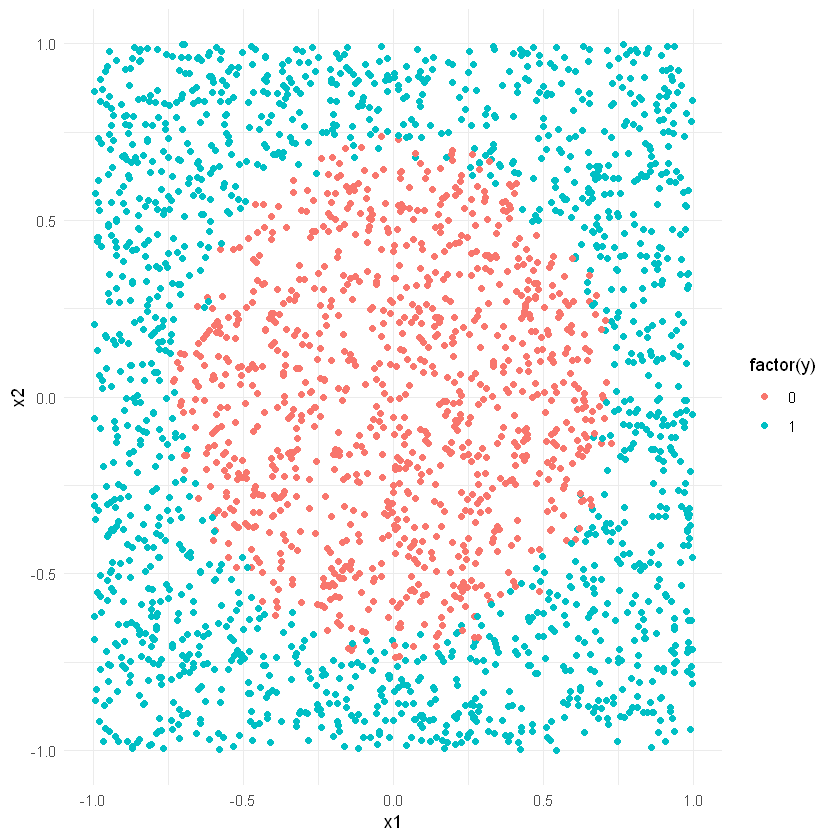

In [3]:
# plot if the training data
ggplot(data=na.omit(train), aes(x=x1, y=x2, colour=factor(y))) + 
        geom_point() + theme_minimal()

2. Train two perceptron models on the loaded training data by setting the learning rates η to .01 and .09 respectively, using a code from Activity 3.1. Calculate the test errors of two models and find the best η and its corresponding model, then plot the test data while the points are colored with their estimated class labels using the best model that you have selected; attach the plot to your PDF report.

   Hint: Note that you must remove NA records from the datasets (using “complete.cases()’ function). You may also choose to change the labels from [0, 1] to [-1, +1] for your convenience. If you decided to use the code from Activity 3.1, you may need to change some initial settings (e.g., epsilon and tau.max). Finally, remember that perceptron is sensitive to initial weights. Therefore, we recommend to run your code a few times with different initial weights.

In [4]:
# Removing Null data points in the train and test data
train = train[complete.cases(train),]
test = test[complete.cases(test),]

In [5]:
train.data = train[c(1, 2)]
train.label = train[,3]

test.data = test[c(1, 2)]
test.label = test[,3]

In [6]:
#perceptron model function

train_perceptron <- function(train.data, train.label, eta=0.01, epsilon=0.001, tau.max=100, trace=FALSE) {
    
    Phi = as.matrix(cbind(1, train.data)) # Add column for bias
    T = ifelse(train.label == 1, 1, -1)
          
    W = matrix(,nrow=tau.max, ncol=ncol(Phi)) # Empty weights
    W[1,] = 2*runif(ncol(Phi))-1 # Initialize weights
    
    error.trace = data.frame("tau"=1:tau.max, "error"=0) # Placeholder for errors
    error.trace[1,"error"] = sum((Phi %*% W[1,]) * T < 0) / nrow(Phi) # record error for initial weights
    
    tau = 1 # iteration counter 
    terminate = FALSE # termination status
    
    
    while(!terminate){
        # Reshuffle data
        train.index = sample(1:nrow(Phi), replace = FALSE)
        Phi = Phi[train.index,]
        T = T[train.index]
        
        for (i in 1:nrow(Phi)){
            if (tau == tau.max) {break}
            
            # look for missclassified samples
            if ((W[tau,] %*% Phi[i,]) * T[i] < 0) {
            
                # update tau counter
                tau = tau +1
            
                # update the weights
                W[tau,] = W[tau-1,] + eta * Phi[i,] * T[i]
            
                # update the records
                error.trace[tau, "error"] = sum((Phi %*% W[tau,]) * T < 0) / nrow(Phi)
            }
            
        }
        
        # decrease learning rate
        eta = eta * 0.99
        
        # recalculate termination conditions
        terminate <- tau >= tau.max | 
        abs(sum((Phi %*% W[tau,]) * T < 0) / nrow(Phi) - sum((Phi %*% W[tau-1,]) * T < 0) / nrow(Phi)) <= epsilon  
    }
    
    if (trace == TRUE) { 
        error_plot = ggplot(data=error.trace, aes(x=tau, y=error)) + 
                        geom_line() + 
                        geom_point() +
                        ggtitle(paste("error rate at eta=", eta))
    
        print(error_plot)
    }
    
    return (W[tau,])
}

#test error calc function
calculate_test_error <- function(test.data, test.label, W){
    Phi = as.matrix(cbind(1, test.data))
    T = ifelse(test.label == 1, 1, -1)
    error = sum((Phi %*% W) * T < 0) / nrow(Phi) * 100
    return (error)
}

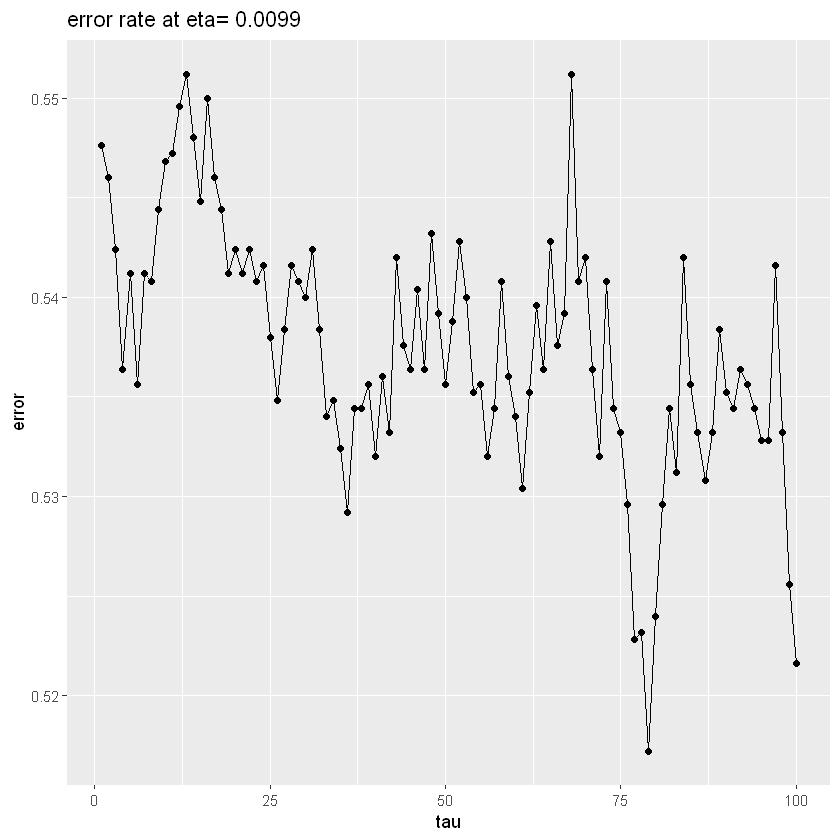

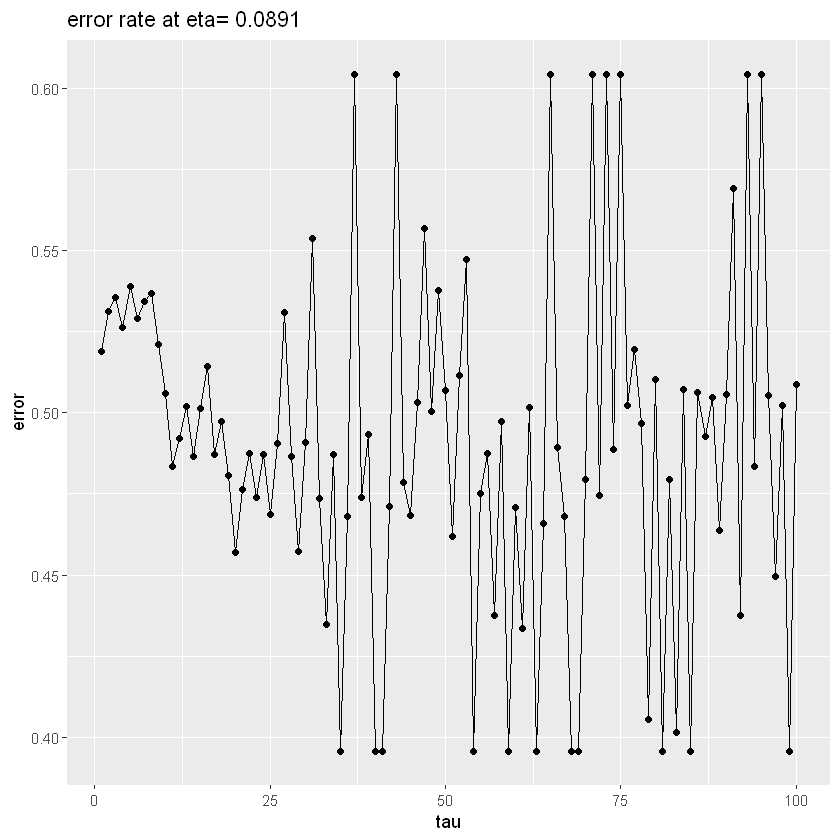

In [7]:
# training experiment with learning rate = 0.01
W = train_perceptron(train.data, train.label, eta=0.01, trace=TRUE)


# training experiment with learning rate = 0.09
W = train_perceptron(train.data, train.label, eta=0.09, trace=TRUE)

In [8]:
train_and_test <- function(train.data, train.label, test.data, test.label, runs=100, eta=0.01){
    error = data.frame("error"=rep(0.0, runs))
    weights = matrix(nrow=runs, ncol=3)
    for (i in 1:runs){
        W = train_perceptron(train.data, train.label, eta=eta)
        error[i,] =  calculate_test_error(test.data, test.label, W)
        weights[i,] = W
    }
    return (list("error"= error, "weights"=weights))
}

In [9]:
output_01 = train_and_test(train.data, train.label, test.data, test.label, eta=0.01)
sprintf("Minimum test error with learning rate %f is: %f",0.01, min(output_01$error))

output_09 = train_and_test(train.data, train.label, test.data, test.label, eta=0.09)
sprintf("Minimum test error with learning rate %f is: %f",0.09, min(output_09$error))

[1] "Minimum test error with learning rate 0.010000 is: 39.080000"

[1] "Minimum test error with learning rate 0.090000 is: 39.080000"

In [10]:
W = output_09$weights[sort(output_09$error[,1], index.return=TRUE)$ix[1],]
Phi = as.matrix(cbind(1, test.data))
T = ifelse(test.label == 1, 1, -1)

In [11]:
estimates = ifelse((Phi %*% W) < 0, -1, 1) 
estimates = cbind(test.data, estimates)

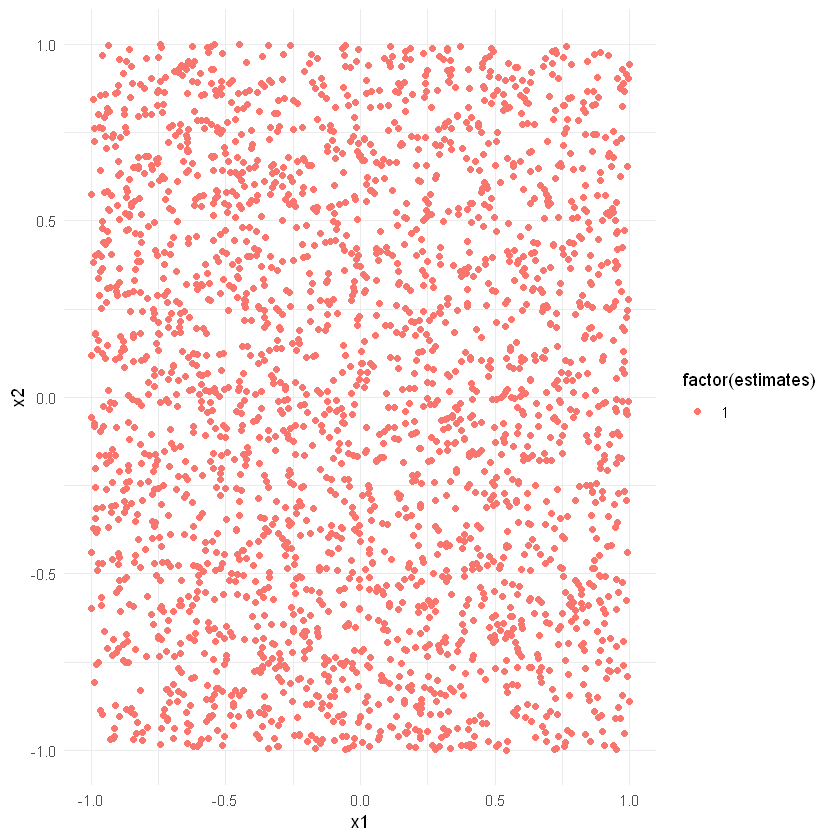

In [12]:
ggplot(data=estimates, aes(x=x1, y=x2, colour=factor(estimates))) + 
        geom_point() + 
theme_minimal()

3. For each combination of K (i.e, number of units in the hidden layer) in {5, 10, 15, …, 100} and μ (learning rate) in {0.01, 0.09}, run the 3-layer Neural Network given to you in Activity 5.1 and record testing error for each of them (40 models will be developed, based on all possible combinations). Plot the error for μ 0.01 and 0.09 vs K (one line for μ 0.01 and another line for μ 0.09 in a plot) and attach it to your PDF report. Based on this plot, find the best combination of K and μ and the corresponding model, then plot the test data while the points are colored with their estimated class labels using the best model that you have selected; attach the plot to your PDF report.

In [13]:
tanh <- function(z){
    return ((exp(z)-exp(-z))/(exp(z)+exp(-z)))
}

tanh.d <- function(z) {
    return (1-(tanh(z))^2)
}

In [14]:
# feedforward step
feedforward <- function(Xi, W1, b1, W2, b2){
    # hidden layer
    z1 = W1 %*% Xi + b1
    a1 = tanh(z1)
    
    # output layer
    z2 = W2 %*% a1 + b2
    a2 = tanh(z2)
    
    return (list(a1, a2, z1, z2))
}

# backpropogation step
backpropagation <- function(Ti, W2, z1, z2, a2){
    # output layer
    d2 = -(Ti-a2) * tanh.d(z2)
    # hidden layer
    d1 =  t(W2) %*% d2  * tanh.d (z1)
    
    return (list(d1,d2))
}

In [15]:
nn.predict <- function(X, W1, W2, b1, b2, threshold=0){
  return (ifelse(prediction.prob(X, W1, W2, b1, b2)>=threshold, 1, 0))
}

#prediction probability function
prediction.prob <- function(X, W1, W2, b1, b2){
  a1 = tanh(sweep(W1 %*% X, 1, b1,'+' ))
  a2 = tanh(sweep(W2 %*% a1, 1, b2,'+' ))
  return (a2)
}

#error rate function
error_rate <- function(test.label, test.pred){
    return (sum(test.label != test.pred) / ncol(test.label))
}

In [16]:
nn.train <- function(X_train, Y_train, X_test, Y_test, eta=0.1, epoch.max=100, lambda=0.1, K=3, trace=FALSE) {
    D = nrow(X_train)
    N = ncol(X_train)
    # hidden layer
    W1 = matrix(rnorm(D*K, sd=0.5), nrow=K, ncol=D)
    b1 = matrix(rnorm(1*K, sd=0.5), nrow=K, ncol=1)

    # output layer
    W2 = matrix(rnorm(K*1, sd=0.5), nrow=1, ncol=K)
    b2 = matrix(rnorm(1*1, sd=0.5), nrow=1, ncol=1)
    
    if (trace == TRUE){
        errors = data.frame("epoch"=1:epoch.max, "train"=0, "test"=0)
    }
    
    for (epoch in 1:epoch.max){
        ## delta vectors/matrices initialization
        # hidden layer delta - partial derivatives
        W1.d = W1 * 0.0
        b1.d = b1 * 0.0

        # output layer delta - partial derivatives
        W2.d = W2 * 0.0
        b2.d = b2 * 0.0
        
        shuffle_datapoints = sample(1:ncol(X_train), replace = FALSE)
        X_train = X_train[, shuffle_datapoints]
        Y_train = t(Y_train[shuffle_datapoints])

        for (i in 1:N){
            # forward pass - feedforward
            forward_pass <- feedforward(X_train[,i], W1, b1, W2, b2)
            a1 = forward_pass[[1]]
            a2 = forward_pass[[2]]
            z1 = forward_pass[[3]]
            z2 = forward_pass[[4]]

            # backword pass - backpropogation
            backword_pass = backpropagation(Y_train[i], W2, z1, z2, a2)
            d1 = backword_pass[[1]]
            d2 = backword_pass[[2]]
            # calculating the delta values for hidden and output layers
            ## hidden layer
            W1.d = W1.d + d1 %*% t(X_train[,i])
            b1.d = b1.d + d1
            ## output layer
            W2.d = W2.d + d2 %*% t(a1)
            b2.d = b2.d + d2
        }

        # update weight vectors and matrices
        ## hidden layer
        W1 = W1 - eta * (W1.d / N + lambda * W1)
        b1 = b1 - eta * (b1.d / N)
        ## output layer
        W2 = W2 - eta * (W2.d / N + lambda * W2)
        b2 = b2 - eta * (b2.d / N)
        
        if (trace == TRUE){
            errors[epoch, "train"] = error_rate(Y_train, nn.predict(X_train, W1, W2, b1, b2))
            errors[epoch, "test"] = error_rate(Y_test, nn.predict(X_test, W1, W2, b1, b2))
            
        }

    }
    return (list("error"=errors, "W1"=W1, "W2"=W2, "b1"=b1, "b2"=b2))
}

In [17]:
X_train = t(unname(data.matrix(train.data))) 
Y_train = t(unname(data.matrix(as.numeric(train.label)))) 
X_test = t(unname(data.matrix(test.data))) 
Y_test = t(unname(data.matrix(as.numeric(test.label))))

Warning message:
"Removed 10 row(s) containing missing values (geom_path)."
Warning message:
"Removed 10 rows containing missing values (geom_point)."


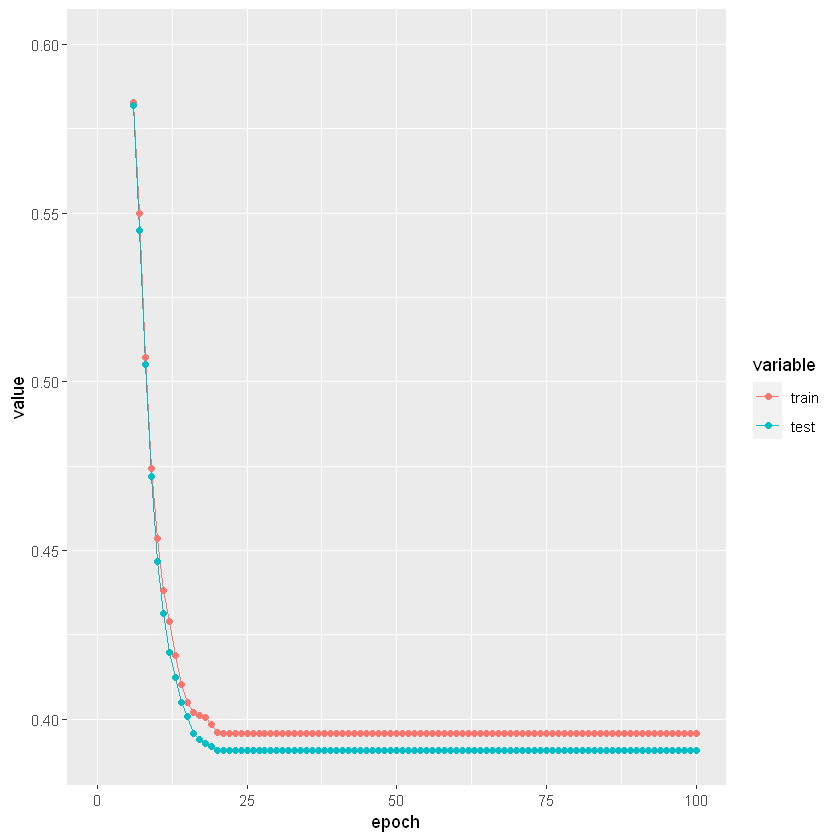

In [18]:
output = nn.train(X_train, Y_train, X_test, Y_test, eta=0.01, K=100, epoch.max=100, lambda=0.001, trace=TRUE)

error_m = melt(output$error, id="epoch")
error_plot = ggplot(data=error_m, aes(x=epoch, y=value, colour=variable)) + 
             geom_line() + geom_point() +
             xlim(0, 100) +
             ylim(min(error_m$value), 0.6)
error_plot

In [19]:
k_values = seq(5, 100, 5)
errors = data.frame("K"=k_values, "mu0.01"=0, "mu0.09"=0)
min_error = 1.0
min_eta = 0.0
min_K = 0
 
for (eta in c(0.01, 0.09)) {
    for (k in k_values) {
        
        output = nn.train(X_train, Y_train, eta=eta, K=k, epoch.max=500, lambda=0.001)
        
        error = error_rate(Y_test, nn.predict(X_test, output$W1, output$W2, output$b1, output$b2))
        if (error < min_error){
            min_error = error
            min_eta=eta
            min_K=k
            W1 = output$W1
            W2 = output$W2
            b1 = output$b1
            b2 = output$b2    
            }
        
        if (eta == 0.01) {
            errors[k/5, "mu0.01"] = error
            
        }
        else if (eta == 0.09) {
            errors[k/5, "mu0.09"] = error
        }
            
    }
}

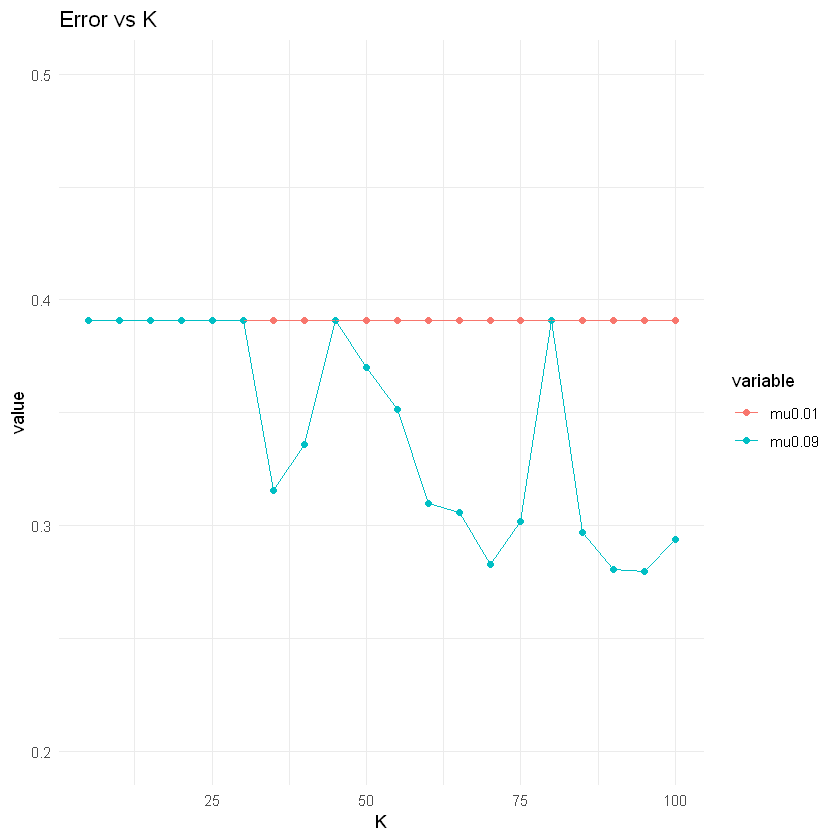

In [20]:
errors_m = melt(errors, id="K")
ggplot(data=errors_m, aes(x=K, y=value, colour=variable)) + 
    geom_point() + geom_line() +
    ylim(0.2, 0.5) +
    ggtitle("Error vs K") +
    theme_minimal()

[1] "Best model with learning rate = 0.09 and size of hidden layers = 95 has error= 0.2796"


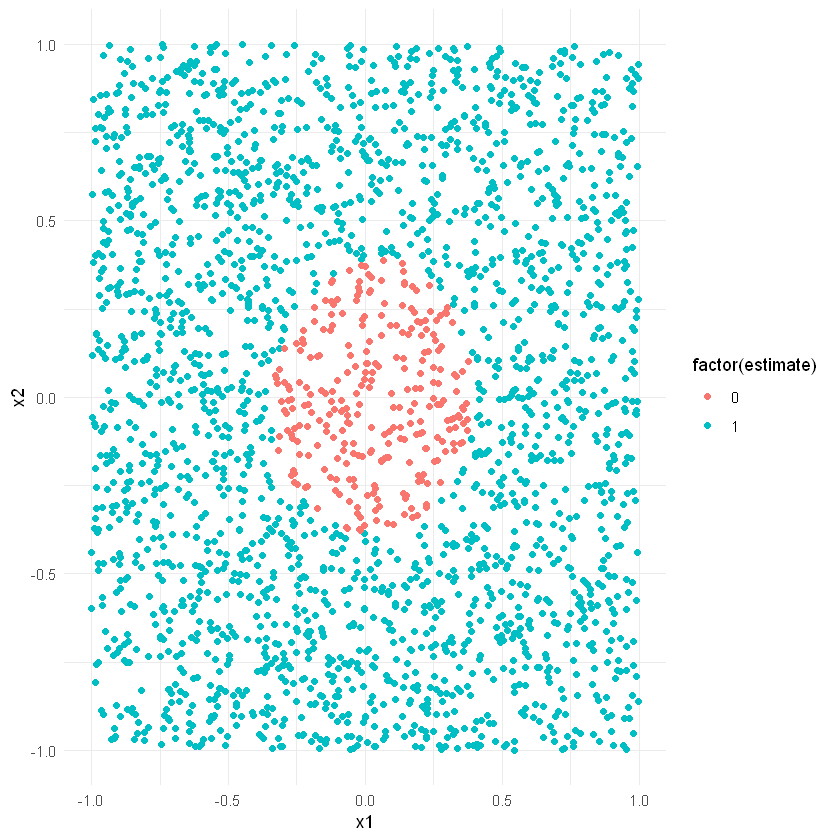

In [21]:
print(paste("Best model with learning rate =", min_eta, "and size of hidden layers =", min_K, "has error=", min_error))
predictions = nn.predict(X_test, W1, W2, b1, b2)
prediction_data = cbind(test.data, "estimate"=t(predictions))

ggplot(data=prediction_data, aes(x=x1, y=x2, colour=factor(estimate))) + 
        geom_point() + 
        theme_minimal()